In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import describe

warnings.filterwarnings("ignore")

from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.impute import KNNImputer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import (
    RandomizedSearchCV,
    StratifiedKFold,
    train_test_split,
)
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from xgboost import XGBClassifier, plot_importance

In [2]:
obese_df = pd.read_csv("/kaggle/input/obesity-or-cvd-risk-classifyregressorcluster/ObesityDataSet.csv")
obese_test_df = pd.read_csv("/kaggle/input/playground-series-s4e2/test.csv")
obese_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

In [3]:
to_cat = obese_df.loc[:, obese_df.nunique() < 8].columns
obese_df[to_cat] = obese_df[to_cat].astype("category").copy()
obese_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   Gender                          2111 non-null   category
 1   Age                             2111 non-null   float64 
 2   Height                          2111 non-null   float64 
 3   Weight                          2111 non-null   float64 
 4   family_history_with_overweight  2111 non-null   category
 5   FAVC                            2111 non-null   category
 6   FCVC                            2111 non-null   float64 
 7   NCP                             2111 non-null   float64 
 8   CAEC                            2111 non-null   category
 9   SMOKE                           2111 non-null   category
 10  CH2O                            2111 non-null   float64 
 11  SCC                             2111 non-null   category
 12  FAF                 

In [4]:
obese_df.describe().round(2).style.format(precision=2).background_gradient(
    vmax=75, cmap="Blues"
)

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.00,2111.00,2111.00,2111.00,2111.00,2111.00,2111.00,2111.00
mean,24.31,1.70,86.59,2.42,2.69,2.01,1.01,0.66
std,6.35,0.09,26.19,0.53,0.78,0.61,0.85,0.61
min,14.00,1.45,39.00,1.00,1.00,1.00,0.00,0.00
25%,19.95,1.63,65.47,2.00,2.66,1.58,0.12,0.00
50%,22.78,1.70,83.00,2.39,3.00,2.00,1.00,0.63
75%,26.00,1.77,107.43,3.00,3.00,2.48,1.67,1.00
max,61.00,1.98,173.00,3.00,4.00,3.00,3.00,2.00


In [5]:
skewness = (
    obese_df.select_dtypes("number")
    .skew()
    .reset_index()
    .rename(columns={"index": "variable", 0: "skewness"})
)
kurtosis = (
    obese_df.select_dtypes("number")
    .kurtosis()
    .reset_index()
    .rename(columns={"index": "variable", 0: "kurtosis"})
)
skewness_kurtosis = pd.concat([skewness, kurtosis["kurtosis"]], axis=1)
skewness_kurtosis.round(2).style.format(precision=2).background_gradient(
    vmax=3, vmin=-1, cmap="Blues"
)

,variable,skewness,kurtosis
0,Age,1.53,2.83
1,Height,-0.01,-0.56
2,Weight,0.26,-0.70
3,FCVC,-0.43,-0.64
4,NCP,-1.11,0.39
5,CH2O,-0.10,-0.88
6,FAF,0.50,-0.62
7,TUE,0.62,-0.55


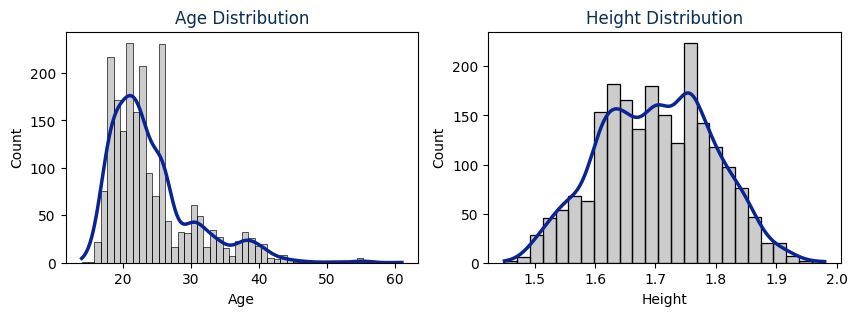

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

ax1 = sns.histplot(
    data=obese_df,
    x="Age",
    kde=True,
    alpha=0.2,
    color="black",
    line_kws={"linewidth": 2.5},
    ax=ax[0],
)
ax2 = sns.histplot(
    data=obese_df,
    x="Height",
    kde=True,
    alpha=0.2,
    color="black",
    line_kws={"linewidth": 2.5},
    ax=ax[1],
)
ax1.set_title("Age Distribution", fontsize=12, color="#0a2e4f")
ax2.set_title("Height Distribution", fontsize=12, color="#0a2e4f")
ax1.lines[0].set_color("#0b2494")
ax2.lines[0].set_color("#0b2494")
plt.show()

In [7]:
obese_df.describe(include="category")

,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS,NObeyesdad
count,2111,2111,2111,2111,2111,2111,2111,2111,2111
unique,2,2,2,4,2,2,4,5,7
top,Male,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation,Obesity_Type_I
freq,1068,1726,1866,1765,2067,2015,1401,1580,351


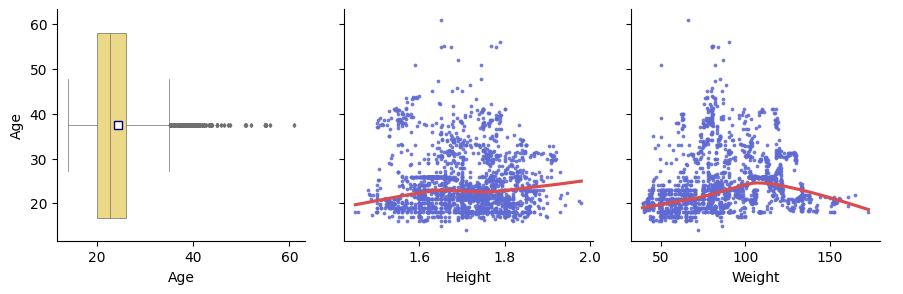

In [8]:
g = sns.PairGrid(
    data=obese_df[["Age", "Height", "Weight", "NObeyesdad"]],
    height=3,
    aspect=1,
    y_vars="Age",
    diag_sharey=False,
)
g.map_upper(
    sns.regplot,
    lowess=True,
    scatter_kws={"s": 3, "color": "#5f6bd2"},
    line_kws={"color": "#db4c4c"},
)
g.map_diag(
    sns.boxplot,
    color="#fde476",
    showmeans=True,
    linewidth=0.5,
    flierprops={"markersize": 2},
    meanprops={
        "marker": "s",
        "markerfacecolor": "white",
        "markeredgecolor": "darkblue",
    },
)
g.add_legend()
plt.show()

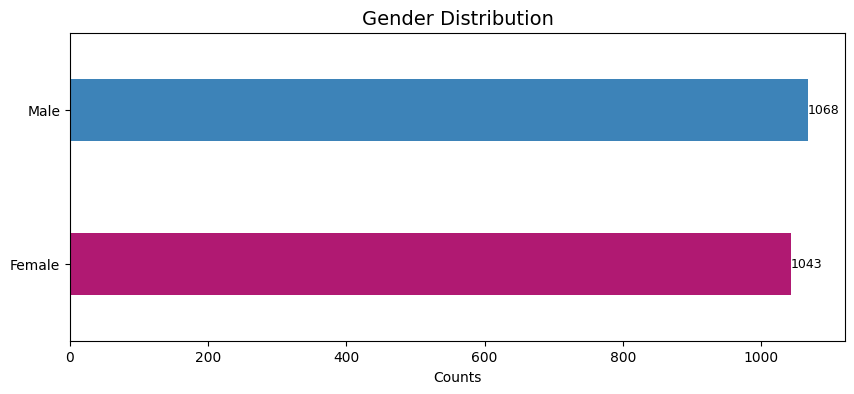

In [9]:
plt.figure(figsize=(10, 4))
ax = sns.countplot(
    data=obese_df,
    y="Gender",
    width=0.4,
    palette={"Female": "#c90076", "Male": "#2986cc"},
    order=obese_df["Gender"].value_counts().index,
)
ax.set_title("Gender Distribution", fontsize=14)
ax.set_ylabel("", fontsize=10)
ax.set_xlabel("Counts", fontsize=10, color="black")
ax.bar_label(ax.containers[0], fontsize=9)
plt.yticks(fontsize=10)
plt.show()

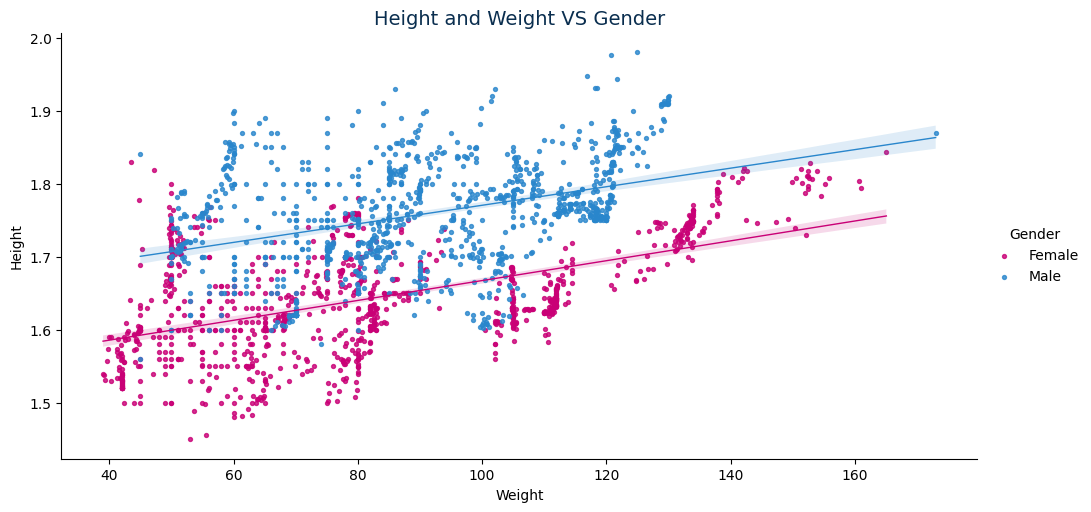

In [10]:
sns.lmplot(
    data=obese_df,
    x="Weight",
    y="Height",
    height=5,
    aspect=2,
    hue="Gender",
    palette={"Female": "#c90076", "Male": "#2986cc"},
    scatter_kws={"s": 8},
    line_kws={"linewidth": 1},
)
plt.title("Height and Weight VS Gender", fontsize=14, color="#0a2e4f")
plt.show()

In [11]:
obese_df[["Gender", "Age", "Height", "Weight"]].groupby("Gender").agg(
    {
        "Age": ["mean", "median", "min", "max", "std"],
        "Height": ["mean", "median", "min", "max", "std"],
        "Weight": ["mean", "median", "min", "max", "std"],
    }
).round(2).stack().reset_index().rename(columns={"level_1": "Metrics"}).style.format(
    precision=2
).background_gradient(
    cmap="Blues"
)

,Gender,Metrics,Age,Height,Weight
0,Female,mean,24.00,1.64,82.30
1,Female,median,22.00,1.64,78.00
2,Female,min,15.00,1.45,39.00
3,Female,max,61.00,1.84,165.06
4,Female,std,6.41,0.07,29.72
5,Male,mean,24.62,1.76,90.77
6,Male,median,23.00,1.76,89.95
7,Male,min,14.00,1.56,45.00
8,Male,max,56.00,1.98,173.00
9,Male,std,6.27,0.07,21.41


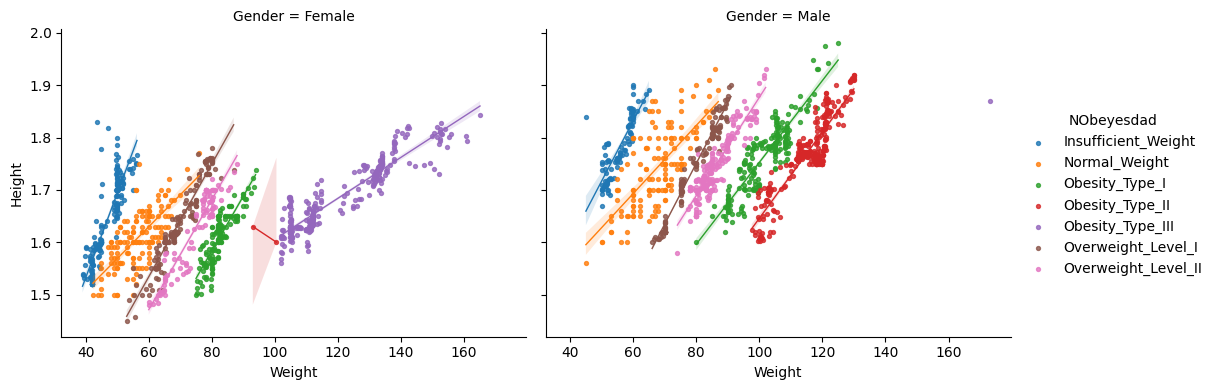

In [12]:
sns.lmplot(
    data=obese_df,
    x="Weight",
    y="Height",
    col="Gender",
    height=4,
    aspect=1.3,
    hue="NObeyesdad",
    scatter_kws={"s": 8},
    line_kws={"linewidth": 1},
    palette="tab10",
)
plt.show()

In [13]:
obese_df[["Gender", "NObeyesdad"]].value_counts().reset_index().style.format(
    precision=2
).background_gradient(cmap="Blues")

,Gender,NObeyesdad,count
0,Female,Obesity_Type_III,323
1,Male,Obesity_Type_II,295
2,Male,Obesity_Type_I,195
3,Male,Overweight_Level_II,187
4,Female,Insufficient_Weight,173
5,Female,Obesity_Type_I,156
6,Male,Normal_Weight,146
7,Male,Overweight_Level_I,145
8,Female,Overweight_Level_I,145
9,Female,Normal_Weight,141


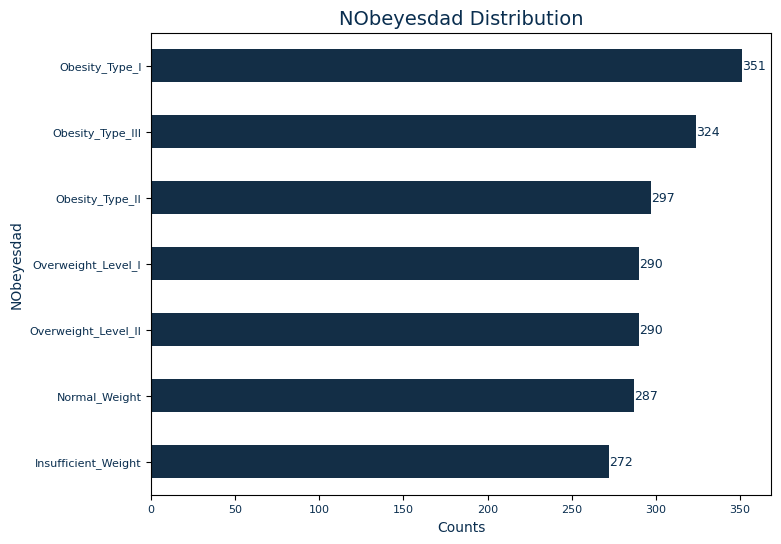

In [14]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(
    data=obese_df,
    y="NObeyesdad",
    color="#0a2e4f",
    order=obese_df["NObeyesdad"].value_counts().index,
    width=0.5,
)

ax.set_title("NObeyesdad Distribution", fontsize=14, color="#0a2e4f")
ax.set_ylabel("NObeyesdad", fontsize=10, color="#0a2e4f")
ax.set_xlabel("Counts", fontsize=10, color="#0a2e4f")
ax.bar_label(ax.containers[0], fontsize=9, color="#0a2e4f")
plt.yticks(fontsize=8, color="#0a2e4f")
plt.xticks(fontsize=8, color="#0a2e4f")
plt.show()

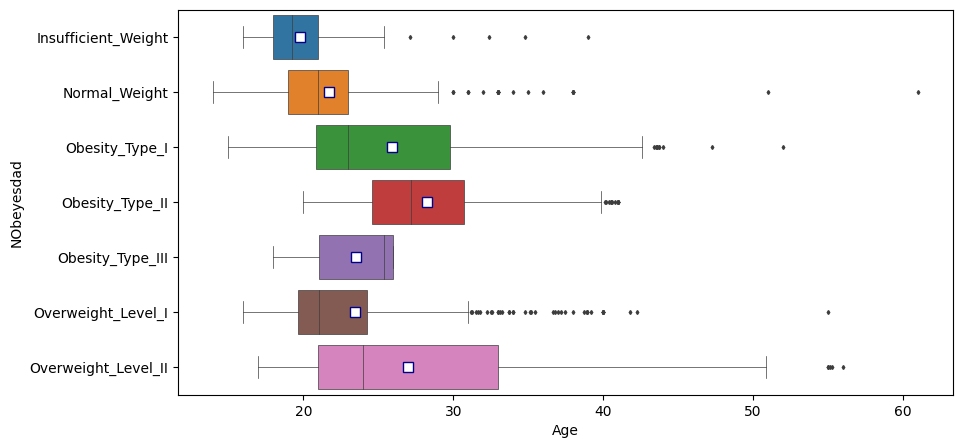

In [15]:
plt.figure(figsize=(10, 5))

sns.boxplot(
    data=obese_df,
    x="Age",
    y="NObeyesdad",
    showmeans=True,
    linewidth=0.5,
    flierprops={"markersize": 2},
    palette="tab10",
    meanprops={
        "marker": "s",
        "markerfacecolor": "white",
        "markeredgecolor": "darkblue",
        "markersize": 7,
    },
)
plt.show()

In [16]:
age_range_target = pd.DataFrame(
    obese_df[["Age", "NObeyesdad"]]
    .groupby("NObeyesdad", as_index=False)
    .agg({"Age": ["min", "max"]})
    .copy()
    .to_records()
)

age_range_target.columns = age_range_target.columns.str.replace(
    r"[^A-a-Z-z0-9]", "", regex=True
)

age_range_target["Range"] = (
    age_range_target[["Agemin", "Agemax"]]
    .astype(str)
    .apply(lambda x: " To ".join(x), axis=1)
)
age_range_target = age_range_target.drop(["Agemin", "Agemax", "index"], axis=1)
age_range_target

,NObeyesdad,Range
0,Insufficient_Weight,16.0 To 39.0
1,Normal_Weight,14.0 To 61.0
2,Obesity_Type_I,15.0 To 52.0
3,Obesity_Type_II,20.0 To 41.0
4,Obesity_Type_III,18.0 To 26.0
5,Overweight_Level_I,16.0 To 55.0
6,Overweight_Level_II,17.0 To 56.0


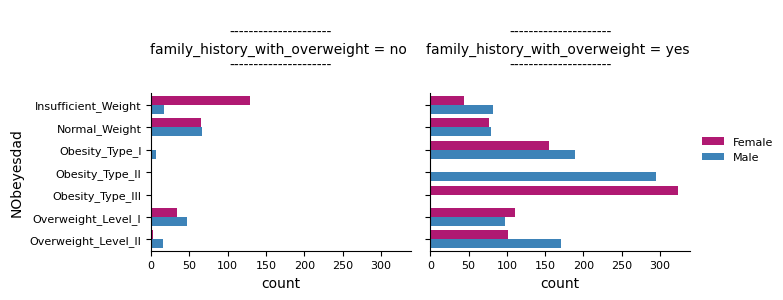

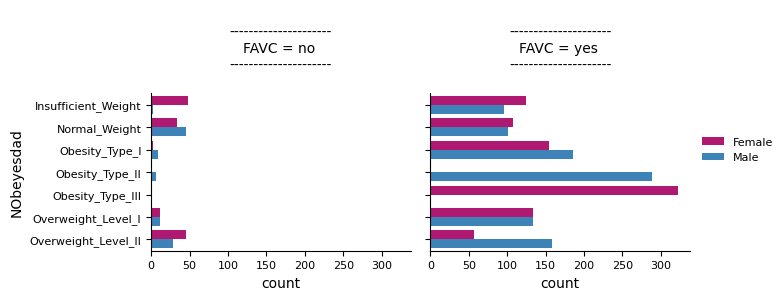

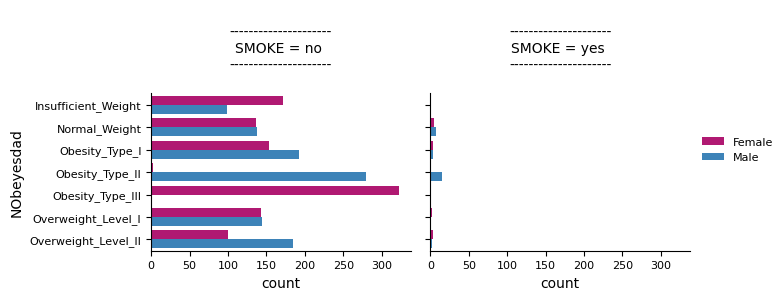

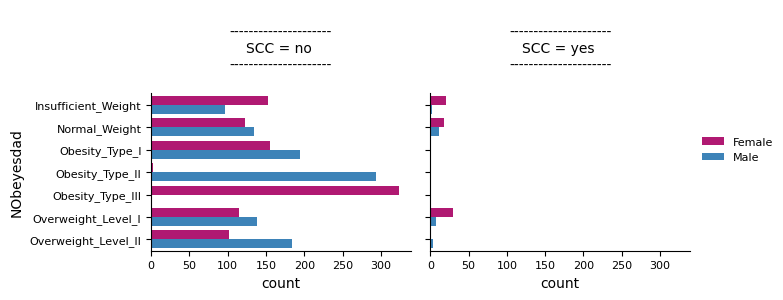

In [17]:
obese_df_yes_no = obese_df.loc[:, obese_df.nunique() == 2]
obese_df_yes_no["NObeyesdad"] = obese_df["NObeyesdad"]
obese_df_yes_no = obese_df_yes_no.columns

for i in obese_df_yes_no[1:5]:
    test = obese_df["Gender"].value_counts()[1]
    g = sns.FacetGrid(data=obese_df, col=i, height=2.5, aspect=1.5)
    g.map_dataframe(
        sns.countplot,
        y="NObeyesdad",
        hue="Gender",
        palette={"Female": "#c90076", "Male": "#2986cc"},
    )
    g.set_titles(
        col_template="\n---------------------\n{col_var} = {col_name} \n---------------------\n"
    )
    g.add_legend(fontsize=8)
    g.tick_params(labelsize=8)

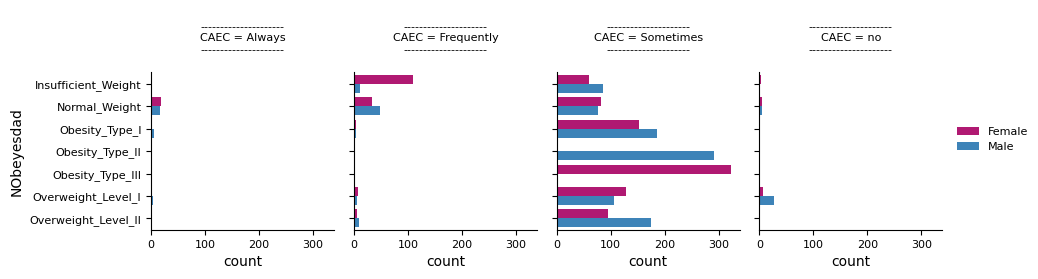

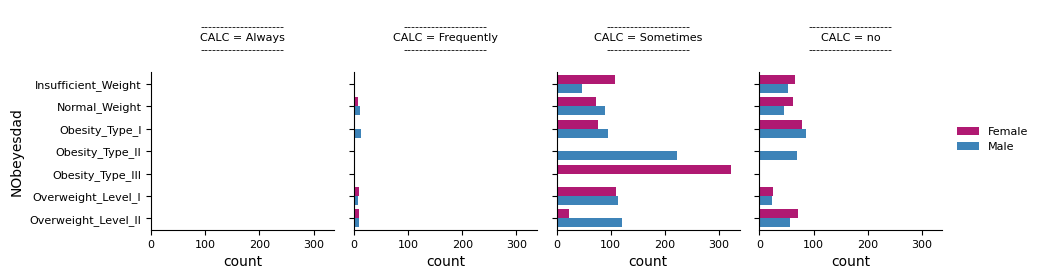

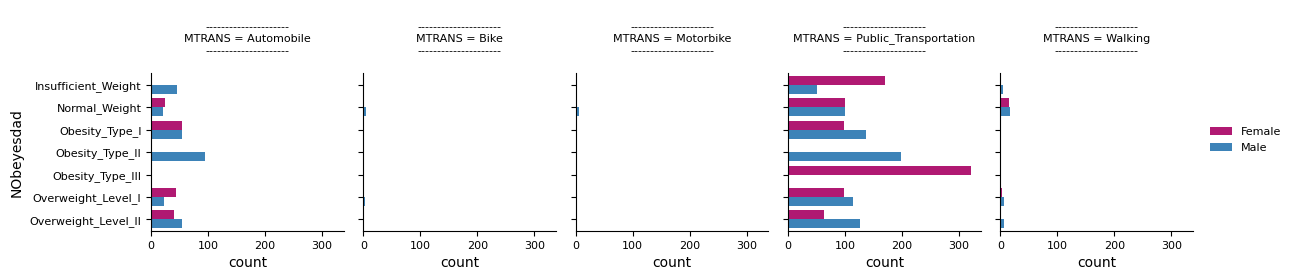

In [18]:
obese_df_grater2 = obese_df[to_cat].loc[:, obese_df[to_cat].nunique() > 2].columns

for i in obese_df_grater2[0:3]:
    g = sns.FacetGrid(data=obese_df, col=i, height=2.5, aspect=1)
    g.map_dataframe(
        sns.countplot,
        y="NObeyesdad",
        hue="Gender",
        palette={"Female": "#c90076", "Male": "#2986cc"},
    )
    g.set_titles(
        col_template="\n---------------------\n{col_var} = {col_name}\n---------------------\n",
        size=8,
    )
    g.add_legend(fontsize=8)
    g.tick_params(labelsize=8)

plt.show()

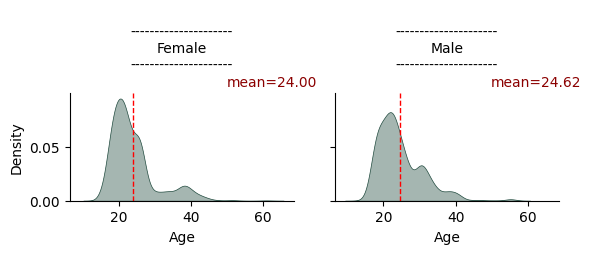

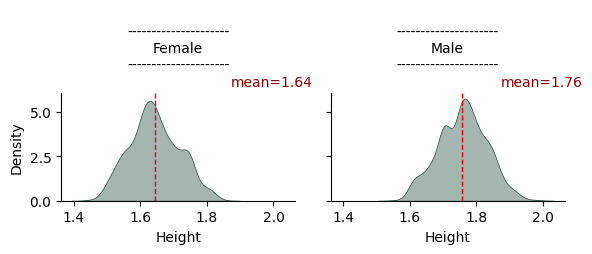

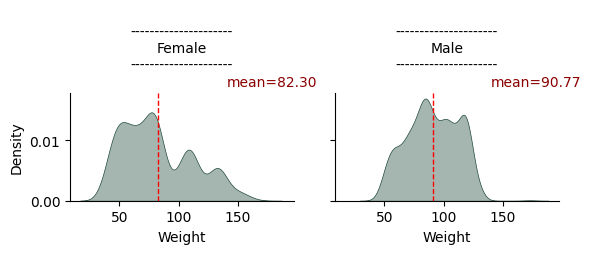

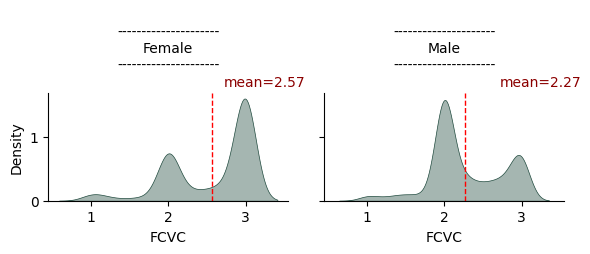

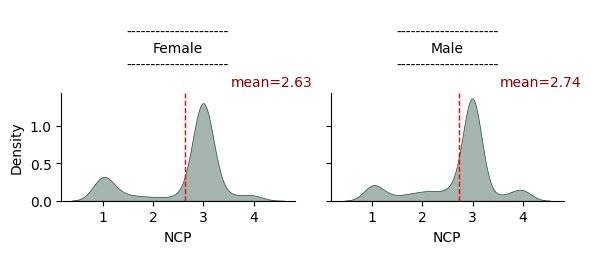

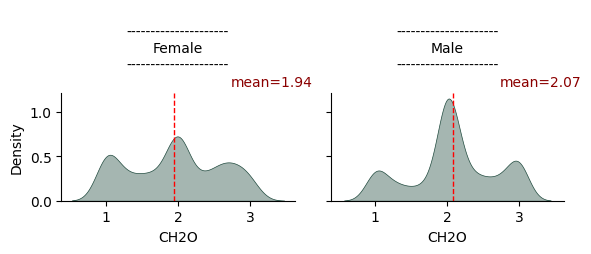

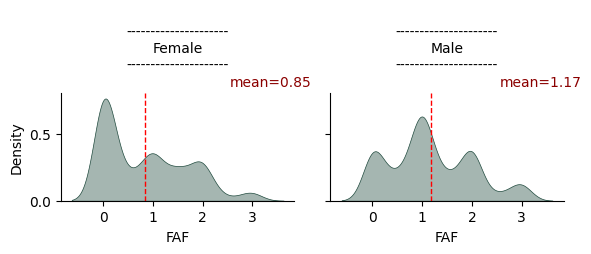

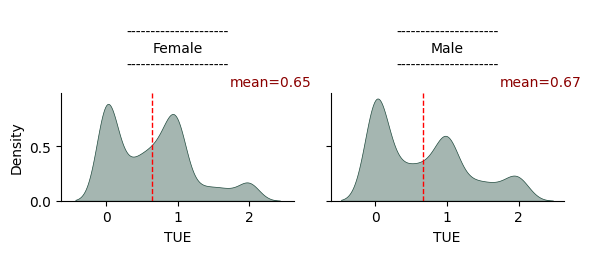

In [19]:
to_num = obese_df.select_dtypes("number").columns


def mean_line(data, var=None, **kws):
    m = np.mean(data[var])
    ax = plt.gca()
    ax.axvline(m, color="red", lw=1, ls="--")
    ax.text(
        0.9,
        1.1,
        f"mean={m:.2f}",
        horizontalalignment="center",
        verticalalignment="center",
        color="darkred",
        transform=ax.transAxes,
    )


for i in to_num:
    g = sns.FacetGrid(data=obese_df, col="Gender", height=2, aspect=1.5)
    g.map_dataframe(
        sns.kdeplot, color="#1f493d", x=i, alpha=0.4, fill=True, linewidth=0.5
    )
    g.map_dataframe(mean_line, data=obese_df, var=i)
    g.set_titles(
        col_template="\n---------------------\n{col_name}\n---------------------\n"
    )

In [20]:
obesity_list = ["Obesity_Type_I", "Obesity_Type_II", "Obesity_Type_III"]
obese_df_obesities = obese_df.query("NObeyesdad in @obesity_list")
obese_df_obesities["NObeyesdad"]  = obese_df_obesities["NObeyesdad"].cat.remove_unused_categories()

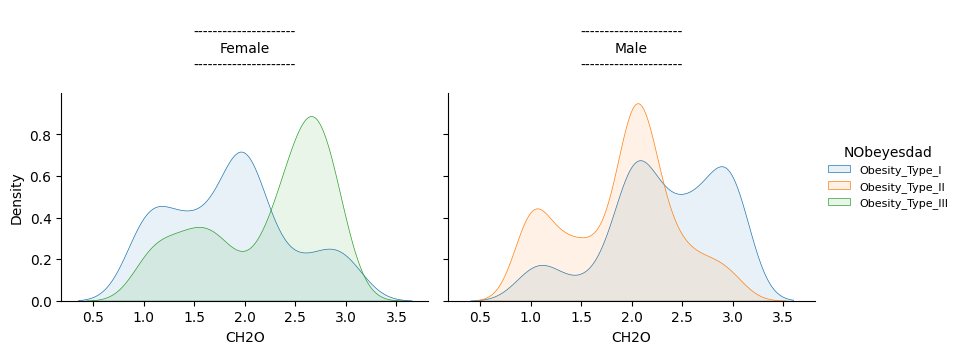

In [21]:
g = sns.FacetGrid(
    data=obese_df_obesities[["Gender", "CH2O", "NObeyesdad"]],
    col="Gender",
    hue="NObeyesdad",
    palette="tab10",
    height=3,
    aspect=1.4,
)
g.map_dataframe(sns.kdeplot, x="CH2O", fill=True, alpha=0.1, linewidth=0.5)
g.set_titles(
    col_template="\n---------------------\n{col_name}\n---------------------\n"
)
g.add_legend(fontsize=8)


plt.show()

In [22]:
obesity_II_III = ["Obesity_Type_I", "Obesity_Type_II", "Obesity_Type_III"]
obese_df[["Gender", "NObeyesdad"]].query(
    "NObeyesdad in @obesity_II_III"
).value_counts().reset_index().style.format(precision=2).background_gradient(
    cmap="Blues"
)

,Gender,NObeyesdad,count
0,Female,Obesity_Type_III,323
1,Male,Obesity_Type_II,295
2,Male,Obesity_Type_I,195
3,Female,Obesity_Type_I,156
4,Female,Obesity_Type_II,2
5,Male,Obesity_Type_III,1


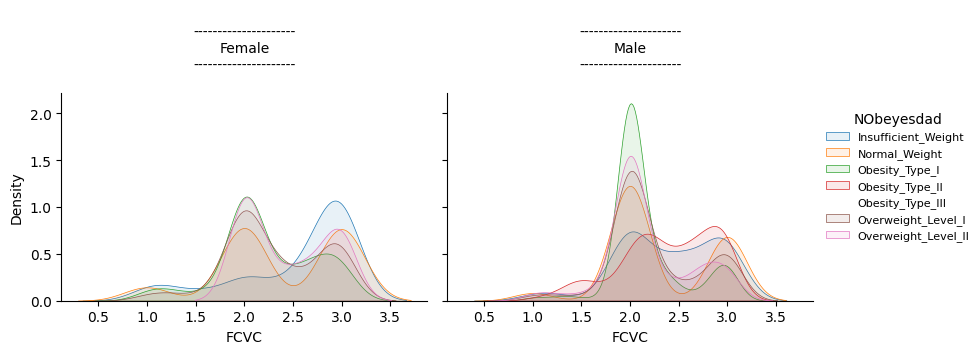

In [23]:
g = sns.FacetGrid(
    data=obese_df[["Gender", "FCVC", "NObeyesdad"]],
    col="Gender",
    hue="NObeyesdad",
    palette="tab10",
    height=3,
    aspect=1.4,
)
g.map_dataframe(sns.kdeplot, x="FCVC", fill=True, alpha=0.1, linewidth=0.5)
g.set_titles(
    col_template="\n---------------------\n{col_name}\n---------------------\n"
)
g.add_legend(fontsize=8)


plt.show()

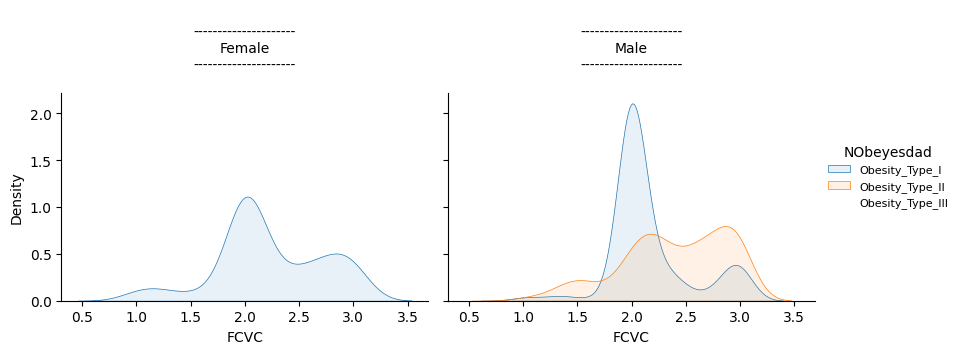

In [24]:
g = sns.FacetGrid(
    data=obese_df_obesities[["Gender", "FCVC", "NObeyesdad"]],
    col="Gender",
    hue="NObeyesdad",
    palette="tab10",
    height=3,
    aspect=1.4,
)
g.map_dataframe(sns.kdeplot, x="FCVC", fill=True, alpha=0.1, linewidth=0.5)
g.set_titles(
    col_template="\n---------------------\n{col_name}\n---------------------\n"
)
g.add_legend(fontsize=8)


plt.show()

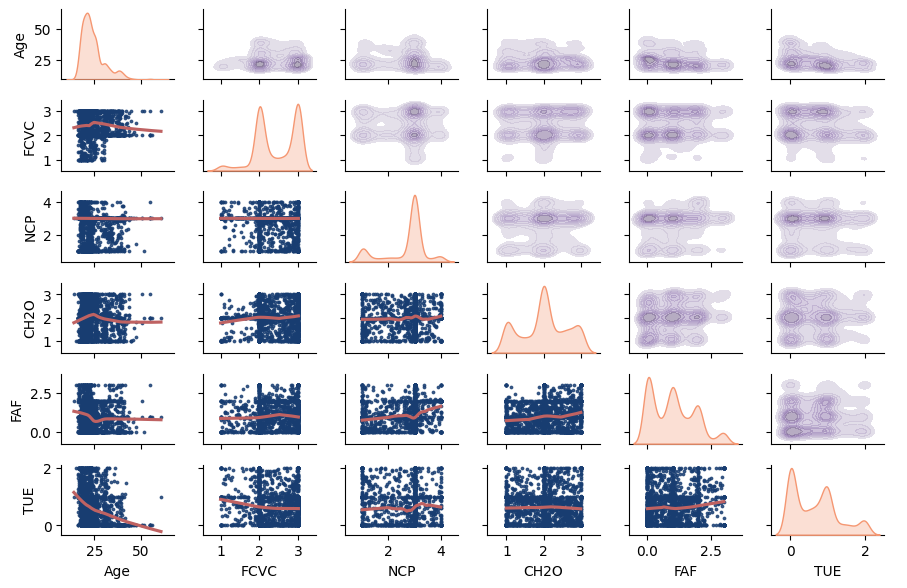

In [25]:
g = sns.PairGrid(
    data=obese_df,
    height=1,
    aspect=1.5,
    vars=["Age", "FCVC", "NCP", "CH2O", "FAF", "TUE"],
    diag_sharey=False,
)
g.map_lower(
    sns.regplot,
    lowess=True,
    scatter_kws={"s": 3, "color": "#183d71"},
    line_kws={"color": "#bf6262"},
)
g.map_diag(sns.kdeplot, color="#f59772", fill=True, alpha=0.3)
g.map_upper(sns.kdeplot, color="#654c80", fill=True, alpha=0.5)
g.add_legend()
plt.show()

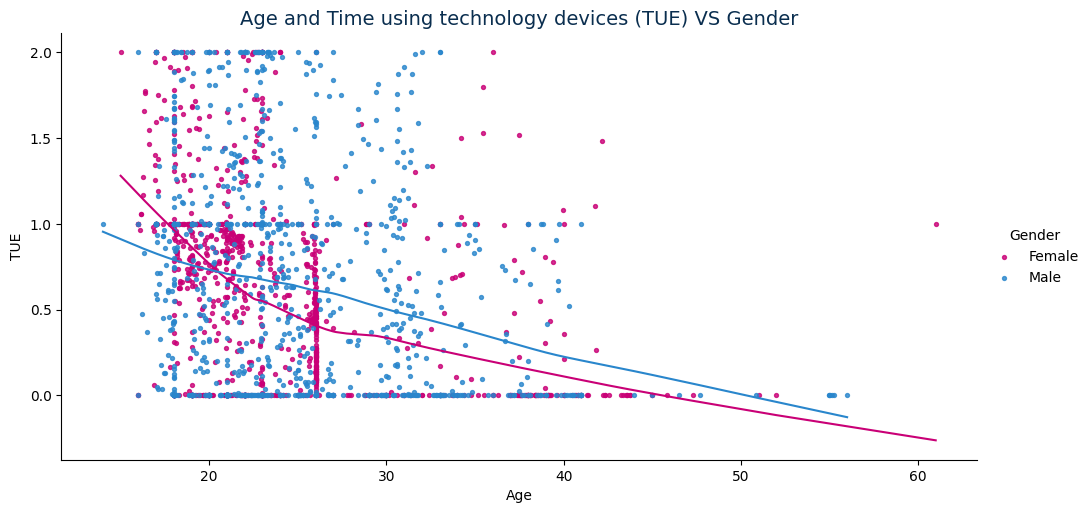

In [26]:
sns.lmplot(
    data=obese_df,
    x="Age",
    y="TUE",
    lowess=True,
    height=5,
    aspect=2,
    hue="Gender",
    palette={"Female": "#c90076", "Male": "#2986cc"},
    scatter_kws={"s": 8},
    line_kws={"linewidth": 1.5},
)
plt.title(
    "Age and Time using technology devices (TUE) VS Gender",
    fontsize=14,
    color="#0a2e4f",
)
plt.show()

In [ ]:
####################################################
cat_cols = ["Gender", 
            "family_history_with_overweight", 
            "FAVC",
            "FCVC", 
            "CAEC", 
            "SMOKE", 
            "SCC", 
            "CALC", 
            "MTRANS"]

####################################################

condlist = [obese_df["NObeyesdad"] == "Insufficient_Weight",
            obese_df["NObeyesdad"] == "Normal_Weight",
            obese_df["NObeyesdad"] == "Obesity_Type_I",
            obese_df["NObeyesdad"] == "Obesity_Type_II",
            obese_df["NObeyesdad"] == "Obesity_Type_III",
            obese_df["NObeyesdad"] == "Overweight_Level_I",
            obese_df["NObeyesdad"] == "Overweight_Level_II",
           ]
choicelist = [0,1,2,3,4,5,6]

obese_df["NObeyesdad"] = np.select(condlist, choicelist)

####################################################

obese_df[cat_cols] = obese_df[cat_cols].apply(LabelEncoder().fit_transform)

####################################################

X = obese_df.drop(columns=[ "NObeyesdad"])
y = obese_df["NObeyesdad"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=345, stratify=y
)


####################################################

params = {
    "min_child_weight": [1, 5, 10],
    "gamma": [0.5, 1, 1.5, 2, 5],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "max_depth": [3, 4, 5],
}

xgb = XGBClassifier(
    n_estimators = 5000,
    objective="multi:softprob",
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.2,
    eval_metric="logloss",
    nthread=1,
)

###################################################

folds = 10
param_comb = 100
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=1001)
random_search = RandomizedSearchCV(
    xgb,
    param_distributions=params,
    n_iter=param_comb,
    scoring="f1_weighted",
    n_jobs=4,
    cv=skf.split(X_train, y_train),
    verbose=1,
    random_state=1001,
)

###################################################

random_search.fit(X_train, y_train)

print(random_search.best_params_)

###################################################

final_xgb = XGBClassifier(
    n_estimators=1000,
    objective="multi:softprob",
    min_child_weight=random_search.best_params_["min_child_weight"],
    gamma=random_search.best_params_["gamma"],
    learning_rate=0.01,
    max_depth=random_search.best_params_["max_depth"],
    subsample=random_search.best_params_["subsample"],
    colsample_bytree=random_search.best_params_["colsample_bytree"],
)

final_xgb.fit(X_train, y_train)

###################################################


accuracy = final_xgb.score(X_test, y_test)
print(accuracy)

####################################################

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = plot_importance(
    final_xgb,
    importance_type="gain",
    show_values=False,
    max_num_features = 15,
    ax=ax,
    title="Feature importance (Gain)",
    xlabel="",
    height=0.7,
    color="#7a1549",
)
ax.bar_label(ax.containers[0], fmt="{:,.01f}", fontsize = 9)
ax.grid(False)

plt.show()

In [ ]:
y_preds = final_xgb.predict(X_test)
print(metrics.classification_report(y_test, y_preds))

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
cm = metrics.confusion_matrix(y_test, y_preds, labels=final_xgb.classes_)

disp = metrics.ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=final_xgb.classes_)
disp.plot(cmap=plt.cm.Reds, ax= ax, 
colorbar=False, text_kw={"fontsize":12})
plt.show()

In [ ]:
obese_test_df[cat_cols] = obese_test_df[cat_cols].apply(LabelEncoder().fit_transform)
obese_test_df = obese_test_df.drop("id", axis = 1)
y_preds_test = final_xgb.predict(obese_test_df)

condlist = [y_preds_test == 0,
            y_preds_test == 1,
            y_preds_test == 2,
            y_preds_test == 3,
            y_preds_test == 4,
            y_preds_test == 5,
            y_preds_test == 6,
           ]
choicelist = ["Insufficient_Weight",
              "Normal_Weight",
              "Obesity_Type_I",
              "Obesity_Type_II",
              "Obesity_Type_III",
              "Overweight_Level_I",
              "Overweight_Level_II"]

y_preds_test = np.select(condlist, choicelist)
y_preds_test